Deep learning is booming. Now with the availability of high-level neural networks API, such as Keras, it is easy to run deep neural networks and solve complex classification problems. Still, from time to time, it is valuable to go back to simple questions and make sure that we fully understand straightforward classification problems instead of running black-box routines with many neurons and layers.

In this post, I would like to ask what is the minimum number of neural-network layers that are needed for the classification of separable features. While this is not a new problem, but I will explore a few aspects of this problem using Keras. In case you wondered, the answer is that 1-layer network can represent half-planes (i.e., the AND or OR logic), 2-layer network can classify points inside any number of arbitrary lines, and 3-layer network can classify any arbitrary shape in arbitrary dimensions. Hence, a 2-layer network can classify any convex set, while 3-layer network can classify any number of disjoint convex or concave shapes.
The rule of thumb says to decrease the size of the layers toward the output layer and that the number of neurons is to be set between the input size and the output size.

But now please allow me to look deeper into a few specific  examples.

In [1]:
from keras import models
from keras import layers

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2018)

/Users/nc374/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Let us start with the most intuitive example. Imagine that we have data that were generated by some polynomial function (see below in blue). Now, we have no way of knowing how the data were created. Still we want to estimate the data with some function. Imagine that the only function that available to us is a linear function. In this case, there is no way that we could estimate the data correctly (see below in black) with zero MSE. The linear function just can't represent the undulations of the generated data.

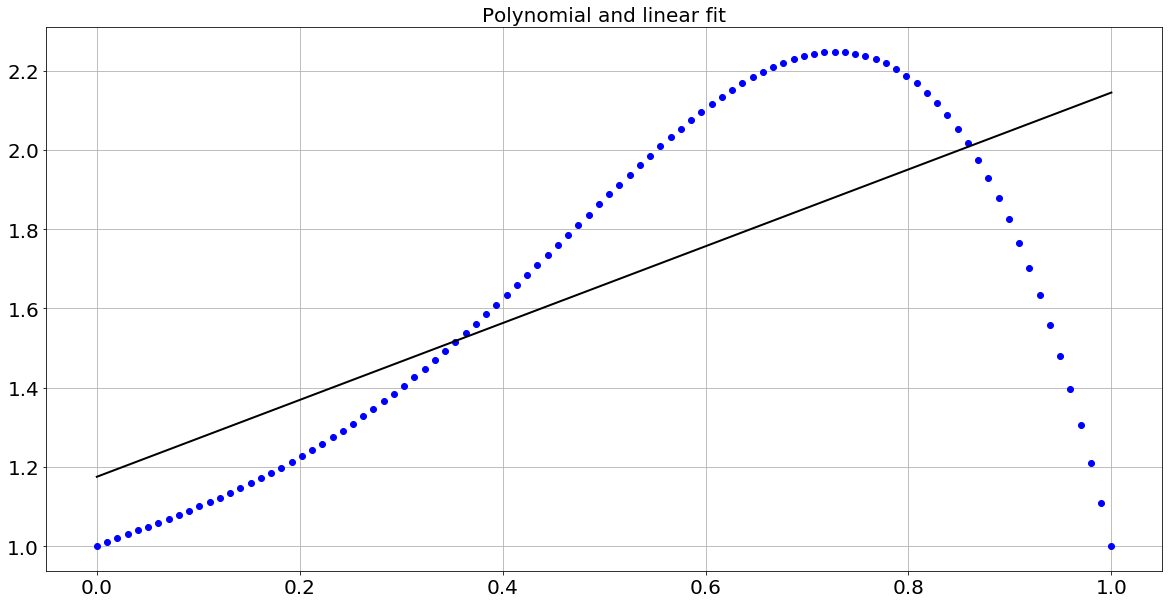

In [4]:
x=np.linspace(0,1,100)
y = 1 + x - x**2 + 10*x**3 - 10*x**4
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.figure(figsize=(20,10))
plt.plot(x,y,'ob',linewidth=2)
plt.plot(x, fit_fn(x),'k',linewidth=2)
plt.title('Polynomial and linear fit',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid('on')
plt.show()

In this post, I ask how many neurons, and layers does a neural network need to classify simple data sets? Next, I will answer this question for the AND, OR, XOR, and the two-moon problem. 

In [6]:
# constants
npts = 100 # points per blob
tot_npts = 4*npts # total number of points 
s = 0.005 # ~standard deviation
sigma = np.array([[s, 0], [0, s]]) #cov matrix

# The AND problem

The AND problem is simple. The data is clustered around four areas: [0,0], [0,1], [1,0], and [1,1]. Then we apply the AND logic function to each pair. It follows that [0,0]=0, [0,1]=0, [1,0]=0, but [1,1]=1. We label the data pair as one (blue) when both points are equal to one. Otherwise, we label the data as zero (red).

(400, 2)
(400,)


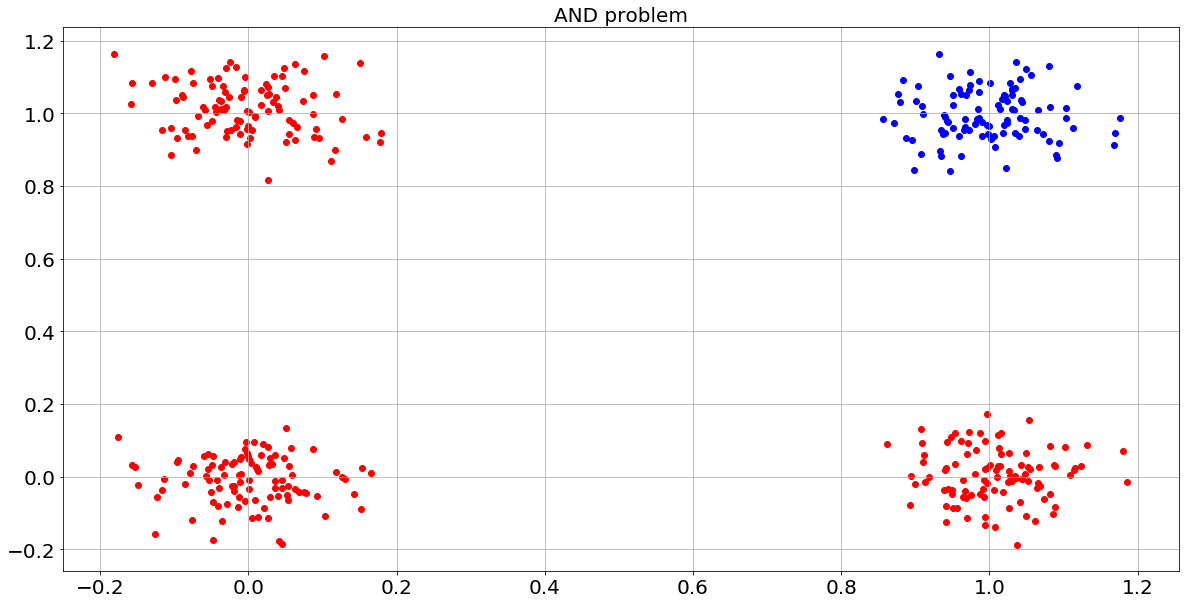

In [7]:
# Generate Data
data1 = np.random.multivariate_normal( [0,0], sigma, npts)
data2 = np.random.multivariate_normal( [0,1], sigma, npts)
data3 = np.random.multivariate_normal( [1,0], sigma, npts)
data4 = np.random.multivariate_normal( [1,1], sigma, npts)

and_data = np.concatenate((data1, data2, data3, data4)) # data
and_labels = np.concatenate((np.ones((3*npts)),np.zeros((npts)))) # labels
print(and_data.shape)
print(and_labels.shape)

plt.figure(figsize=(20,10))
plt.scatter(and_data[:,0][and_labels==0], and_data[:,1][and_labels==0],c='b')
plt.scatter(and_data[:,0][and_labels==1], and_data[:,1][and_labels==1],c='r')

plt.plot()
plt.title('AND problem',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid('on')
plt.show()

Separating the AND data is easy. A straight line can separate the data into the blues and reds. That was easy. Linear line is represented by $ax + b$ or in the neural network world as np.dot(W, x) + b. Thus, one layer with one neuron will suffice for separate the AND data.
I use the sigmoid activation with one layer and one neuron. As a loss function, I chose binary_crossentropy with Adam optimizer. Iterating over the data with batch_size of 16 converge to the right solution, measured by accuracy, after about 100 iterations over the whole data.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


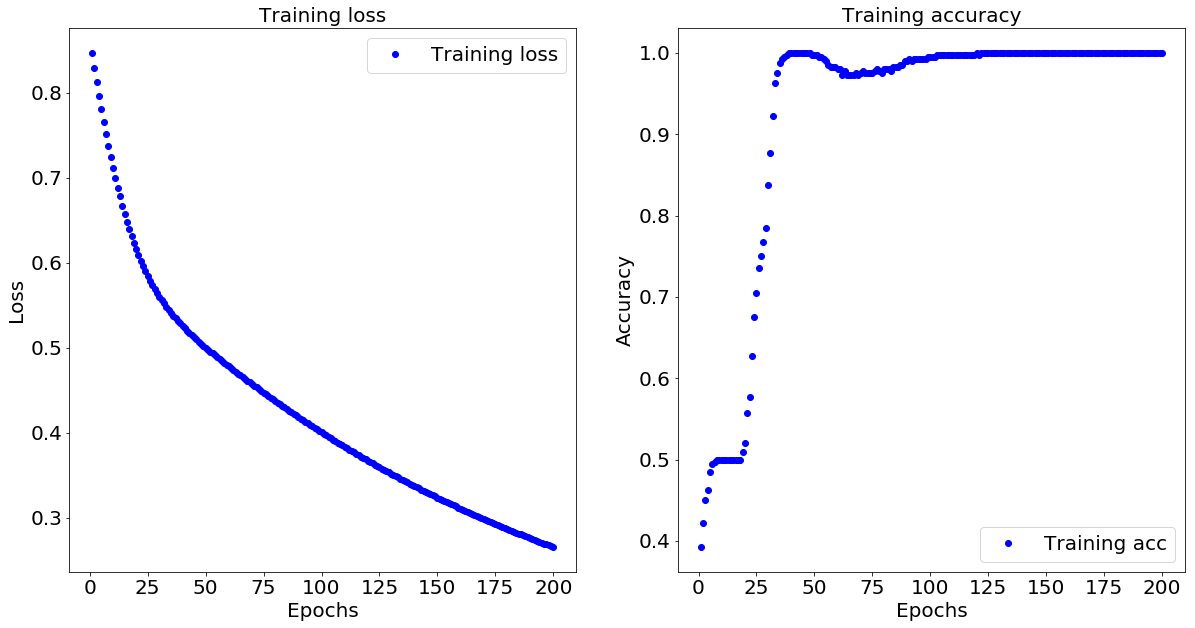

In [8]:
model = models.Sequential()
model.add(layers.Dense(1, activation='sigmoid', input_shape=(2,)))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(and_data, 
                    and_labels, 
                    epochs=200,
                    batch_size=16,
                    verbose=0)


history_dict = history.history
history_dict.keys()


plt.figure(figsize=(20,10))
plt.subplot(121)
loss_values = history_dict['loss']
#val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
#plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training loss',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.subplot(122)
acc_values = history_dict['acc']
#val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
#plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training accuracy',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# The OR problem

The OR problem is also simple. Again, the data is clustered around four areas: [0,0], [0,1], [1,0], and [1,1]. As before, we apply the OR logic function to each pair. It follows that [0,0]=0, but [0,1]=1, [1,0]=1, and [1,1]=1. We label the data pair as zero (red), only when both points are equal to zero. Otherwise, we label the data as one (blue).

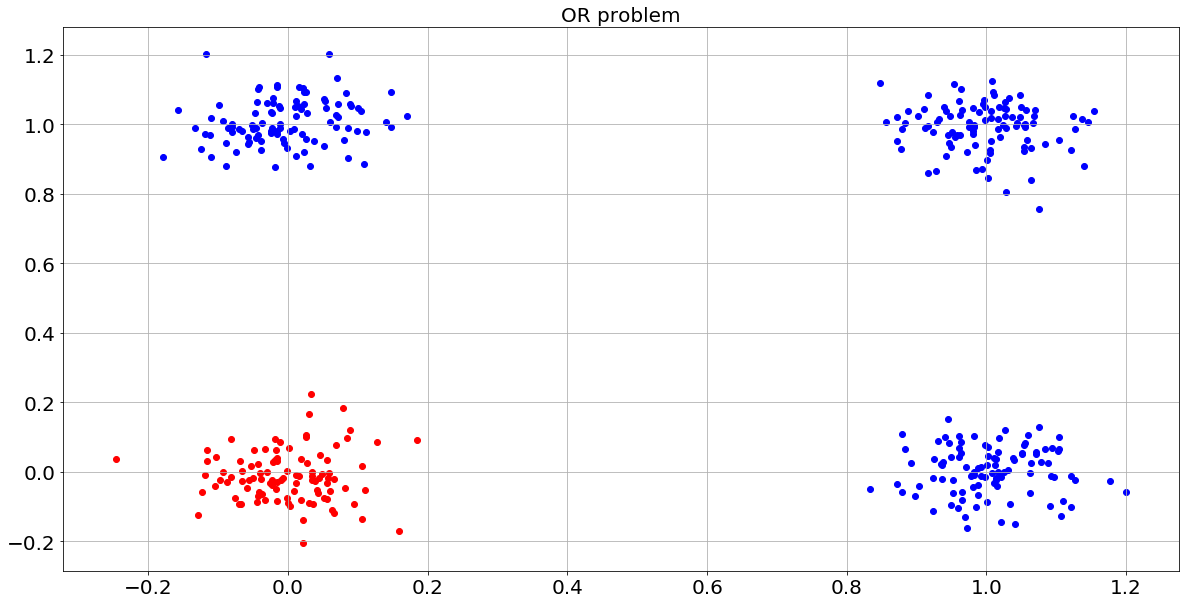

In [9]:
# Generate Data
data1 = np.random.multivariate_normal( [0,0], sigma, npts)
data2 = np.random.multivariate_normal( [0,1], sigma, npts)
data3 = np.random.multivariate_normal( [1,0], sigma, npts)
data4 = np.random.multivariate_normal( [1,1], sigma, npts)

or_data = np.concatenate((data1, data2, data3, data4))
or_labels = np.concatenate((np.ones((npts)),np.zeros((3*npts))))

plt.figure(figsize=(20,10))
plt.scatter(or_data[:,0][or_labels==0], or_data[:,1][or_labels==0],c='b')
plt.scatter(or_data[:,0][or_labels==1], or_data[:,1][or_labels==1],c='r')
plt.title('OR problem',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid('on')
plt.show()

Separating this data is also easy. As for the AND data, a straight line will suffice and as before a neural network with one layer and one neuron will suffice for separate the data.
I use the same architecture as for the ANd problem, and the system converges to the right solution after about 200 iterations.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


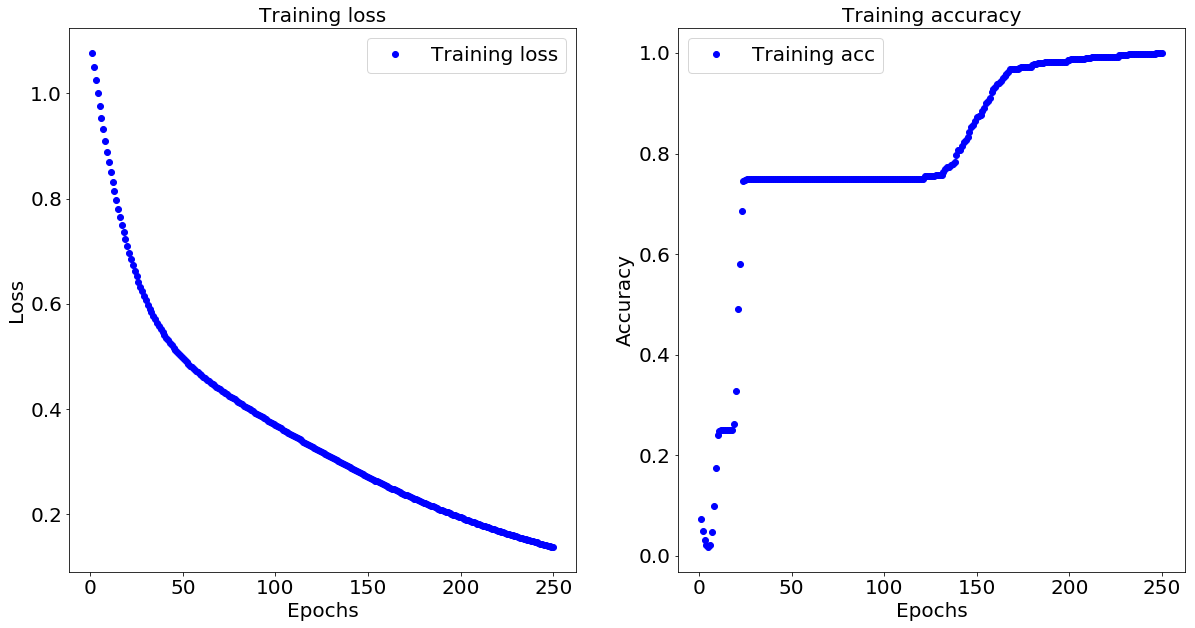

In [10]:
model = models.Sequential()
model.add(layers.Dense(1, activation='sigmoid', input_shape=(2,)))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(or_data, 
                    or_labels, 
                    epochs=250,
                    batch_size=16,
                    verbose=0)


history_dict = history.history
history_dict.keys()


plt.figure(figsize=(20,10))
plt.subplot(121)
loss_values = history_dict['loss']
#val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
#plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training loss',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.subplot(122)
acc_values = history_dict['acc']
#val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
#plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training accuracy',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# The XOR problem

The XOR problem is a bit more difficult. Again, the data points are clustered around four areas, and we apply the XOR logic function to each pair. For the XOR logic the result is that [0,0]=0, and [1,1]=0 but [0,1]=1, and [1,0]=1.

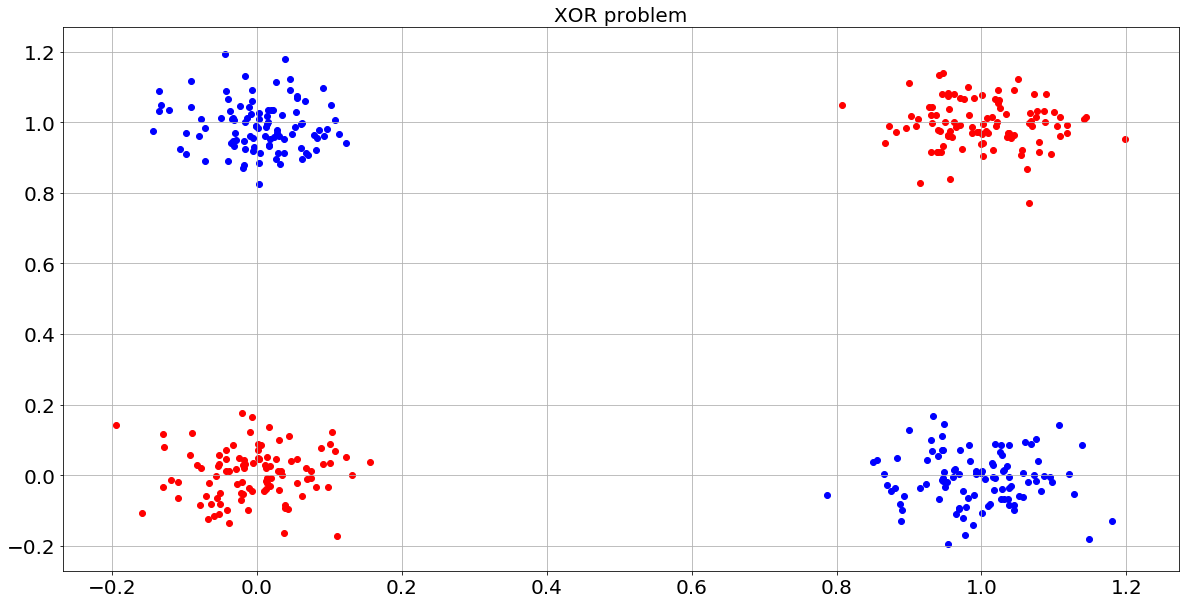

In [11]:
# Generate Data
data1 = np.random.multivariate_normal( [0,0], sigma, npts)
data2 = np.random.multivariate_normal( [0,1], sigma, npts)
data3 = np.random.multivariate_normal( [1,0], sigma, npts)
data4 = np.random.multivariate_normal( [1,1], sigma, npts)

xor_data = np.concatenate((data1, data4, data2, data3))
xor_labels = np.concatenate((np.ones((2*npts)),np.zeros((2*npts))))

plt.figure(figsize=(20,10))
plt.scatter(xor_data[:,0][xor_labels==0], xor_data[:,1][xor_labels==0],c='b')
plt.scatter(xor_data[:,0][xor_labels==1], xor_data[:,1][xor_labels==1],c='r')
plt.title('XOR problem',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid('on')
plt.show()

The problem is that no one straight line can separate the data correctly. However, if as a first step we isolate [0,0] and [1,1] separately using two linear lines, then as a second step, we can apply the AND function to both separations to yield the right solution. 
Thus, a two-step solution is needed: the first applies two linear lines, and the second unite the two separations using an AND logic. Other words, the minimal network is a two-layer neural network, where the first must have two neurons and the second only one.

In [12]:
model = models.Sequential()
model.add(layers.Dense(1, activation='sigmoid', input_shape=(2,)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(xor_data, 
                    xor_labels, 
                    epochs=400,
                    batch_size=32,
                    verbose=0)
history_dict_10 = history.history

model = models.Sequential()
model.add(layers.Dense(1, activation='relu', input_shape=(2,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(xor_data, 
                    xor_labels, 
                    epochs=400,
                    batch_size=32,
                    verbose=0)
history_dict_11 = history.history

model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(2,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(xor_data, 
                    xor_labels, 
                    epochs=400,
                    batch_size=32,
                    verbose=0)
history_dict_21 = history.history


history = model.fit(xor_data, 
                    xor_labels, 
                    epochs=400,
                    batch_size=32,
                    verbose=0)
history_dict_41 = history.history

Indeed one can see that the 2_1 (two layers with two and one neurons) model converge to the right solution, while the 1_0 (one layer with one neuron) and 1_1 (two layers with one and one neurons) networks approximate the data well but never converge to 100% accuracy.

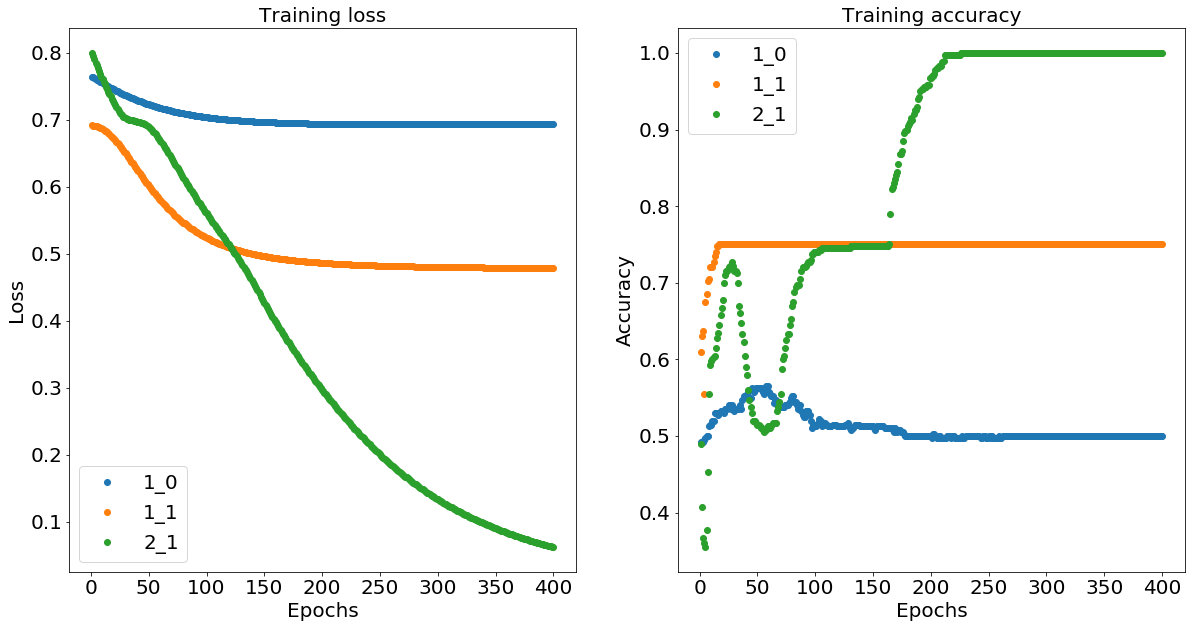

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(121)
loss_values = history_dict_10['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, history_dict_10['loss'], 'o', label='Training loss')
plt.plot(epochs, history_dict_11['loss'], 'o', label='Training loss')
plt.plot(epochs, history_dict_21['loss'], 'o', label='Training loss')
plt.title('Training loss',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(['1_0','1_1','2_1','4_1'],fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.subplot(122)
acc_values = history_dict_10['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, history_dict_10['acc'], 'o', label='Training loss')
plt.plot(epochs, history_dict_11['acc'], 'o', label='Training loss')
plt.plot(epochs, history_dict_21['acc'], 'o', label='Training loss')
plt.title('Training accuracy',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(['1_0','1_1','2_1','4_1'],fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# The two-moon problem

The two moon problem is well known. Data points with a two moon shape are facing each other while slightly shifted horizontally. What is the minimal number of neurons and layers that are needed to separate the moons?

In [14]:
import sklearn.datasets as sk  
tm_data, tm_labels = sk.make_moons(n_samples=400, shuffle=True, noise=0.05, random_state=0)
print(tm_data.shape)
print(tm_labels.shape)

(400, 2)
(400,)


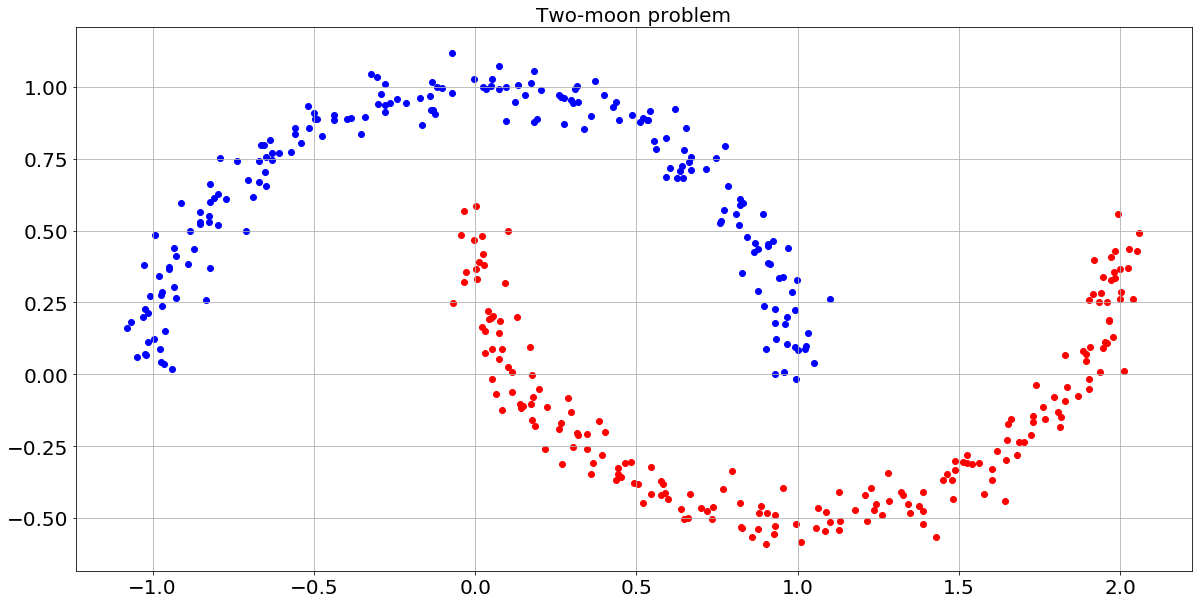

In [15]:
plt.figure(figsize=(20,10))
plt.scatter(tm_data[:,0][tm_labels==0],tm_data[:,1][tm_labels==0],c='b')
plt.scatter(tm_data[:,0][tm_labels==1],tm_data[:,1][tm_labels==1],c='r')
plt.title('Two-moon problem',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid('on')
plt.show()

At this point I recommend you to take a piece of paper and try to isolate the red moon from the blue moon using only straight lines. 
What is the minimal number of straight lines that are needed?
You will find that four lines are needed: two lines near one end of the red moon and two on the other end of the red moon. 
So, the first step is to place the four lines. The second step is to apply the AND logic to each edge pair - this forms two triangle areas. The third step is to apply the OR logic to the two triangles to isolate the red moon from the blue.
Overall, the minimum network will have three layers- the first layer will have four neurons, the second two and the third one.

In [16]:
model = models.Sequential()
model.add(layers.Dense(1, activation='sigmoid', input_shape=(2,)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(tm_data, 
                    tm_labels, 
                    epochs=600,
                    batch_size=32,
                    verbose=0)

history_dict = history.history

model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(2,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(tm_data, 
                    tm_labels, 
                    epochs=600,
                    batch_size=32,
                    verbose=0)

history_dict_21 = history.history

model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(2,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(tm_data, 
                    tm_labels, 
                    epochs=600,
                    batch_size=32,
                    verbose=0)

history_dict_41 = history.history

model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(2,)))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(tm_data, 
                    tm_labels, 
                    epochs=600,
                    batch_size=32,
                    verbose=0)

history_dict_221 = history.history

model = models.Sequential()
model.add(layers.Dense(3, activation='relu', input_shape=(2,)))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(tm_data, 
                    tm_labels, 
                    epochs=600,
                    batch_size=32,
                    verbose=0)

history_dict_321 = history.history

model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(2,)))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(tm_data, 
                    tm_labels, 
                    epochs=600,
                    batch_size=32,
                    verbose=0)

history_dict_421 = history.history

Indeed one can see that the 4_2_1 (three layers with four, two, and one neurons) model converge to the right solution, while the 2_1, 4_1, 2_2_1 ,3_2_1 networks approximate the data well but never converge to 100% accuracy.

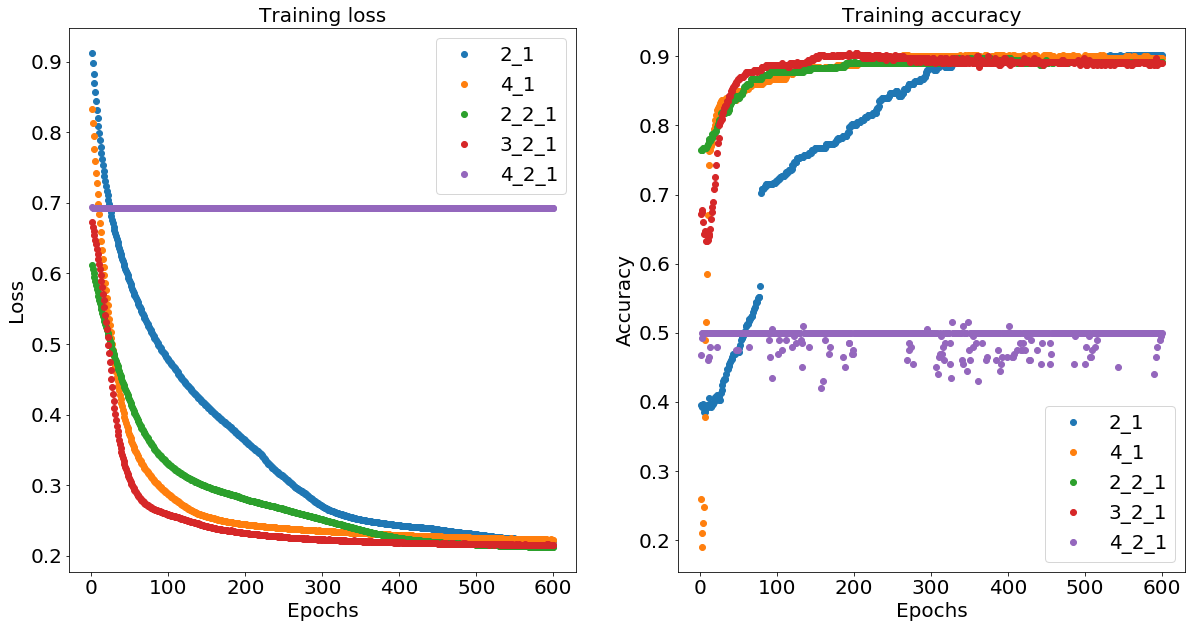

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(121)
loss_values = history_dict_21['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, history_dict_21['loss'], 'o', label='Training loss')
plt.plot(epochs, history_dict_41['loss'], 'o', label='Training loss')
plt.plot(epochs, history_dict_221['loss'], 'o', label='Training loss')
plt.plot(epochs, history_dict_321['loss'], 'o', label='Training loss')
plt.plot(epochs, history_dict_421['loss'], 'o', label='Training loss')

plt.title('Training loss',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(['2_1','4_1','2_2_1','3_2_1','4_2_1'],fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.subplot(122)
acc_values = history_dict_21['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, history_dict_21['acc'], 'o', label='Training loss')
plt.plot(epochs, history_dict_41['acc'], 'o', label='Training loss')
plt.plot(epochs, history_dict_221['acc'], 'o', label='Training loss')
plt.plot(epochs, history_dict_321['acc'], 'o', label='Training loss')
plt.plot(epochs, history_dict_421['acc'], 'o', label='Training loss')

plt.title('Training accuracy',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(['2_1','4_1','2_2_1','3_2_1','4_2_1'],fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()